# ORF recognition by LSTM
LSTM was incapable of ORF recognition on 1000 bp sequences. Try smaller.


In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 17:28:55 UTC'

In [2]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=100            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 20000 PC seqs
Train on 20000 NC seqs


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(LSTM(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(LSTM(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (100, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 26s 9ms/step - loss: 0.6811 - accuracy: 0.5524 - val_loss: 0.6543 - val_accuracy: 0.6190


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6393 - accuracy: 0.6410 - val_loss: 0.6170 - val_accuracy: 0.6604


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5830 - accuracy: 0.6940 - val_loss: 0.3687 - val_accuracy: 0.8576


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3644 - accuracy: 0.8537 - val_loss: 0.3383 - val_accuracy: 0.8630


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3441 - accuracy: 0.8566 - val_loss: 0.3613 - val_accuracy: 0.8399
Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3445 - accuracy: 0.8525 - val_loss: 0.3742 - val_accuracy: 0.8200
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3721 - accuracy: 0.8225 - val_loss: 0.3834 - val_accuracy: 0.8104
Epoch 8/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3941 - accuracy: 0.8108 - val_loss: 0.3954 - val_accuracy: 0.8027
Epoch 9/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3835 - accuracy: 0.8156 - val_loss: 0.4175 - val_accuracy: 0.8322
Epoch 10/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3670 - accuracy: 0.8374 - val_loss: 0.3378 - val_accuracy: 0.8581
Epoch 11/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3608 - accuracy: 0.8455 - val_loss: 0.3377 - val_accurac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3259 - accuracy: 0.8607 - val_loss: 0.3239 - val_accuracy: 0.8610
Epoch 15/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3310 - accuracy: 0.8613 - val_loss: 0.3228 - val_accuracy: 0.8614
Epoch 16/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3176 - accuracy: 0.8633 - val_loss: 0.3018 - val_accuracy: 0.8704


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3104 - accuracy: 0.8665 - val_loss: 0.3104 - val_accuracy: 0.8783


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3026 - accuracy: 0.8752 - val_loss: 0.3056 - val_accuracy: 0.8708
Epoch 19/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2735 - accuracy: 0.8931 - val_loss: 0.2845 - val_accuracy: 0.8866


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2687 - accuracy: 0.8965 - val_loss: 0.2196 - val_accuracy: 0.9200


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2272 - accuracy: 0.9179 - val_loss: 0.2311 - val_accuracy: 0.9120
Epoch 22/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2206 - accuracy: 0.9192 - val_loss: 0.1944 - val_accuracy: 0.9319


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2101 - accuracy: 0.9247 - val_loss: 0.2954 - val_accuracy: 0.8876
Epoch 24/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2585 - accuracy: 0.9059 - val_loss: 0.1730 - val_accuracy: 0.9429


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2936 - accuracy: 0.8866 - val_loss: 0.1806 - val_accuracy: 0.9384
Epoch 26/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2143 - accuracy: 0.9242 - val_loss: 0.2169 - val_accuracy: 0.9236
Epoch 27/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2047 - accuracy: 0.9307 - val_loss: 0.3155 - val_accuracy: 0.8626
Epoch 28/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3146 - accuracy: 0.8679 - val_loss: 0.2255 - val_accuracy: 0.9202
Epoch 29/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3908 - accuracy: 0.7769 - val_loss: 0.6931 - val_accuracy: 0.5067
Epoch 30/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6946 - accuracy: 0.4958 - val_loss: 0.6915 - val_accuracy: 0.5318
Epoch 31/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6840 - accuracy: 0.5518 - val_loss: 0.6907 - val_ac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1634 - accuracy: 0.9463 - val_loss: 0.1612 - val_accuracy: 0.9480


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1760 - accuracy: 0.9404 - val_loss: 0.1699 - val_accuracy: 0.9474
Epoch 50/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1799 - accuracy: 0.9384 - val_loss: 0.1556 - val_accuracy: 0.9505


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 1, 50 epochs, 544 sec


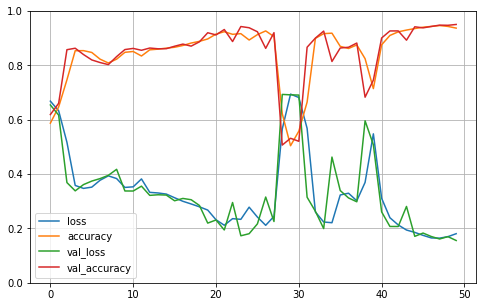

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6974 - accuracy: 0.5138 - val_loss: 0.6613 - val_accuracy: 0.6104
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6600 - accuracy: 0.6142 - val_loss: 0.6323 - val_accuracy: 0.6480
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6296 - accuracy: 0.6521 - val_loss: 0.6156 - val_accuracy: 0.6658
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6010 - accuracy: 0.6765 - val_loss: 0.5060 - val_accuracy: 0.7549
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4346 - accuracy: 0.8081 - val_loss: 0.3728 - val_accuracy: 0.8584
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3438 - accuracy: 0.8587 - val_loss: 0.3300 - val_accuracy: 0.8660
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3276 - accuracy:

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1611 - accuracy: 0.9449 - val_loss: 0.2236 - val_accuracy: 0.9191
Epoch 32/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2010 - accuracy: 0.9287 - val_loss: 0.1705 - val_accuracy: 0.9420
Epoch 33/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1658 - accuracy: 0.9449 - val_loss: 0.1516 - val_accuracy: 0.9523
Epoch 34/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1436 - accuracy: 0.9519 - val_loss: 0.1911 - val_accuracy: 0.9325
Epoch 35/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1623 - accuracy: 0.9460 - val_loss: 0.1422 - val_accuracy: 0.9553


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1436 - accuracy: 0.9526 - val_loss: 0.1379 - val_accuracy: 0.9565


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1367 - accuracy: 0.9563 - val_loss: 0.1383 - val_accuracy: 0.9538
Epoch 38/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1459 - accuracy: 0.9513 - val_loss: 0.1471 - val_accuracy: 0.9553
Epoch 39/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1479 - accuracy: 0.9516 - val_loss: 0.1401 - val_accuracy: 0.9536
Epoch 40/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1353 - accuracy: 0.9563 - val_loss: 0.2240 - val_accuracy: 0.9209
Epoch 41/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1788 - accuracy: 0.9361 - val_loss: 0.1355 - val_accuracy: 0.9606


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 42/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1401 - accuracy: 0.9542 - val_loss: 0.1497 - val_accuracy: 0.9503
Epoch 43/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1234 - accuracy: 0.9598 - val_loss: 0.3373 - val_accuracy: 0.8913
Epoch 44/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2371 - accuracy: 0.9109 - val_loss: 0.1514 - val_accuracy: 0.9473
Epoch 45/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1398 - accuracy: 0.9556 - val_loss: 0.3789 - val_accuracy: 0.8509
Epoch 46/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2420 - accuracy: 0.9132 - val_loss: 0.1889 - val_accuracy: 0.9398
Epoch 47/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1357 - accuracy: 0.9549 - val_loss: 0.1324 - val_accuracy: 0.9585
Epoch 48/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1223 - accuracy: 0.9619 - val_loss: 0.1299 - val_ac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1284 - accuracy: 0.9598 - val_loss: 0.1802 - val_accuracy: 0.9274
Epoch 50/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1533 - accuracy: 0.9469 - val_loss: 0.1395 - val_accuracy: 0.9531
Fold 2, 50 epochs, 468 sec


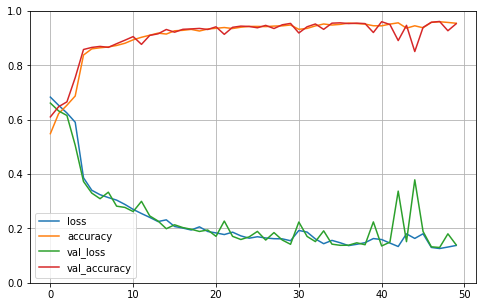

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6808 - accuracy: 0.5528 - val_loss: 0.6610 - val_accuracy: 0.6009
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6523 - accuracy: 0.6175 - val_loss: 0.6245 - val_accuracy: 0.6566
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6214 - accuracy: 0.6534 - val_loss: 0.5936 - val_accuracy: 0.6821
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5743 - accuracy: 0.6998 - val_loss: 0.3393 - val_accuracy: 0.8633
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3409 - accuracy: 0.8583 - val_loss: 0.3133 - val_accuracy: 0.8640
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3218 - accuracy: 0.8632 - val_loss: 0.2986 - val_accuracy: 0.8804
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3098 - accuracy:

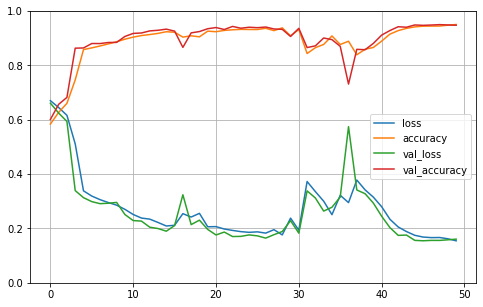

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6858 - accuracy: 0.5374 - val_loss: 0.6581 - val_accuracy: 0.6127
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6563 - accuracy: 0.6114 - val_loss: 0.6240 - val_accuracy: 0.6485
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6138 - accuracy: 0.6644 - val_loss: 0.4829 - val_accuracy: 0.7814
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4054 - accuracy: 0.8296 - val_loss: 0.3370 - val_accuracy: 0.8637
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3367 - accuracy: 0.8618 - val_loss: 0.3536 - val_accuracy: 0.8593
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3371 - accuracy: 0.8616 - val_loss: 0.3323 - val_accuracy: 0.8572
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3262 - accuracy:

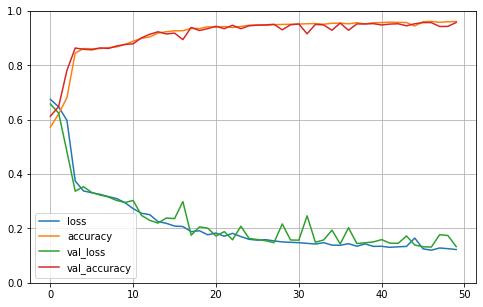

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6775 - accuracy: 0.5641 - val_loss: 0.6534 - val_accuracy: 0.6189
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6421 - accuracy: 0.6336 - val_loss: 0.6325 - val_accuracy: 0.6428
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6142 - accuracy: 0.6613 - val_loss: 0.6023 - val_accuracy: 0.6618
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5914 - accuracy: 0.6741 - val_loss: 0.5706 - val_accuracy: 0.6923
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5556 - accuracy: 0.7034 - val_loss: 0.5534 - val_accuracy: 0.7032
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5242 - accuracy: 0.7317 - val_loss: 0.4387 - val_accuracy: 0.8019
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3890 - accuracy:

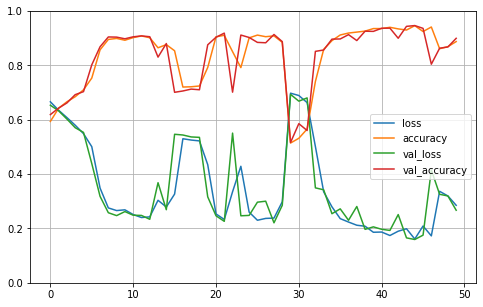

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 96.85%


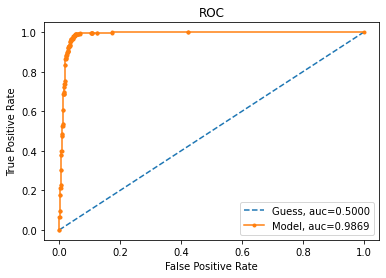

AUC: 0.99%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 18:08:02 UTC'